## Notebook 10
#### Giorgio Stucchi - 969107

In [10]:
# importazione librerie
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
import string
from scipy.optimize import curve_fit
import networkx as nx
warnings.filterwarnings('ignore')
params = {'legend.fontsize': 'x-large', 'figure.figsize': (10, 6), 'axes.labelsize': 'x-large', 'axes.titlesize':'xx-large', 'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

The genetic algorithm in Exercise09 was upgraded using MPI Libraries. The algorithm operates on 10 separate populations, each consisting of 1000 individuals. Each individual has a genome that represents a path through 34 randomly placed cities (or American cities with given coordinates, in the second Exercise). By harnessing parallel computation, the populations evolve independently for a total of 100 steps (200 for american cities). Every 10 (or 20) steps, the 10 best paths of the populations are randomly exchanged between different populations.

To determine the sender and recipient of each path exchange, a randomly shuffled sequence is generated every 10 steps, containing the numbers 0 to 9. The order of this sequence determines the communication pattern between the populations. That is, the sender vector (0, 1,.., 9) is associated to the receiver sequence (shuffled(0, 1,.., 9)).

After the full evolution is completed, we plot the best path for one of the 10 processes. Since we want to compare the parallel algorithm's performance with that of the non parallelized algorithm, we also run 10 indipendent processes, i.e., with no communication. We then compare one of the parallelized processes with one of the non communicating one. Finally we compare the best process (that is, the one that yields the shortest path) for both options. This is repeated for circumference map, square map and american cities.

In [11]:
def plot_all(folder_name, process):
    fig, axs = plt.subplots(1,2,figsize=(14,7))

    #Plotto la posizione delle città
    file = open (folder_name+'/map.dat', 'r')
    mappa = []
    mappa = [line.split() for line in file]

    G = nx.Graph()

    for city in mappa:
        G.add_node(city[0], pos=[float(city[1]),float(city[2])])

    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(3,figsize=(5,5)) 
    nx.draw(G, ax=axs.flat[0], pos=pos, node_size=100)
    axs.flat[0].set(title = "City Network");

    #Plotto il miglior percorso trovato
    file = open (folder_name+'/BestPath'+process+'.dat','r')
    path = []
    path = [line.split() for line in file]

    G.add_edges_from(path)

    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(4,figsize=(5,5)) 
    nx.draw(G, ax=axs.flat[1], pos=pos, node_size=100, edge_color = 'red')
    axs.flat[1].set(title = "Minimum distance Path" + process);

    plt.show()

    best = np.loadtxt(folder_name+"/best_fitness"+process+".dat")
    media = np.loadtxt(folder_name+"/besthalf_fitness"+process+".dat")
    x = np.arange(len(best))

    plt.plot(x, media, label="Best Half Average", alpha=0.3, color = "purple")
    plt.plot(x,best,label="Minimum Length", color = "green")
    plt.xlabel('Generation')
    plt.ylabel('$L^{(1)}$')
    plt.title( r'$L^{(1)}$ vs Generation, '+folder_name+' Map , '+process)
    plt.grid(True)
    plt.legend()
    plt.show()

In [12]:
def confront(folder_name, process1, process2):
    
    fig, axs = plt.subplots(1,2,figsize=(14,7))

    #Plotto la posizione delle città
    file = open ("Parallel" + folder_name+'/map.dat', 'r')
    mappa = []
    mappa = [line.split() for line in file]

    G = nx.Graph()

    for city in mappa:
        G.add_node(city[0], pos=[float(city[1]),float(city[2])])

    #Plotto il miglior percorso trovato
    file = open ("Parallel" + folder_name+'/BestPath'+process1+'.dat','r')
    path = []
    path = [line.split() for line in file]

    G.add_edges_from(path)

    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(3,figsize=(5,5)) 
    nx.draw(G, ax=axs.flat[1], pos=pos, node_size=100, edge_color = 'red')
    axs.flat[1].set(title = "Parallel Minimum distance Path" +process1);
    G.remove_edges_from(path)
    
    #Plotto il miglior percorso trovato
    file = open ("NonCommunicating" + folder_name+'/BestPath'+process2+'.dat','r')
    path = []
    path = [line.split() for line in file]
    
    G.add_edges_from(path)

    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(3,figsize=(5,5)) 
    nx.draw(G, ax=axs.flat[0], pos=pos, node_size=100, edge_color = 'red')
    axs.flat[0].set(title = "NonCommunicating Minimum distance Path"+process2);

    plt.show()
    

    best = np.loadtxt("Parallel" + folder_name+"/best_fitness"+process1+".dat")
    #media = np.loadtxt("Parallel" +folder_name+"/besthalf_fitness"+process+".dat")
    best2 = np.loadtxt("NonCommunicating" +folder_name+"/best_fitness"+process2+".dat")
    #media2 = np.loadtxt("NonCommunicating" +folder_name+"/besthalf_fitness.dat")
    x = np.arange(len(best))

    plt.plot(x, best, label="ParallelBest", alpha=0.3)
    plt.plot(x,best2,label="NonCommunicatingBest")
    plt.xlabel('Generation')
    plt.ylabel('$L^{(1)}$')
    plt.title( r' Parallel' + process1+' vs NonCommunicating' + process2+', '+ folder_name +' Map')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Minimum distance Noncommunicating = ", best2[-1])
    print("Minimum distance Parallel = ", best[-1])

In [13]:
import os

def confront_best(folder_name):
    
    fig, axs = plt.subplots(1,2,figsize=(14,7))

    #Plotto la posizione delle città
    file = open ("Parallel" + folder_name+'/map.dat', 'r')
    mappa = []
    mappa = [line.split() for line in file]

    G = nx.Graph()

    for city in mappa:
        G.add_node(city[0], pos=[float(city[1]),float(city[2])])

    # Find the process with the minimum last fitness in the Parallel folder
    min_fitness_parallel = float('inf')
    min_process_parallel = None
    for process_file in os.listdir("Parallel" + folder_name):
        if process_file.startswith("best_fitness") and process_file.endswith(".dat"):
            process_path = "Parallel" + folder_name + "/" + process_file
            fitness = np.loadtxt(process_path)[-1]
            if fitness < min_fitness_parallel:
                min_fitness_parallel = fitness
                min_process_parallel = process_file[len("best_fitness"):-len(".dat")]

    # Plot the best path for the selected process in the Parallel folder
    if min_process_parallel is not None:
        file_path = "Parallel" + folder_name + '/BestPath' + min_process_parallel + '.dat'
        if os.path.exists(file_path):
            file = open(file_path, 'r')
            path = [line.split() for line in file]
            G.add_edges_from(path)
            pos = nx.get_node_attributes(G, 'pos')
            nx.draw(G, ax=axs.flat[1], pos=pos, node_size=100, edge_color='red')
            axs.flat[1].set(title="Parallel Minimum distance Path")

    # Find the process with the minimum last fitness in the NonCommunicating folder
    min_fitness_noncomm = float('inf')
    min_process_noncomm = None
    for process_file in os.listdir("NonCommunicating" + folder_name):
        if process_file.startswith("best_fitness") and process_file.endswith(".dat"):
            process_path = "NonCommunicating" + folder_name + "/" + process_file
            fitness = np.loadtxt(process_path)[-1]
            if fitness < min_fitness_noncomm:
                min_fitness_noncomm = fitness
                min_process_noncomm = process_file[len("best_fitness"):-len(".dat")]

    # Plot the best path for the selected process in the NonCommunicating folder
    if min_process_noncomm is not None:
        file_path = "NonCommunicating" + folder_name + '/BestPath' + min_process_noncomm + '.dat'
        if os.path.exists(file_path):
            file = open(file_path, 'r')
            path = [line.split() for line in file]
            G.add_edges_from(path)
            pos = nx.get_node_attributes(G, 'pos')
            nx.draw(G, ax=axs.flat[0], pos=pos, node_size=100, edge_color='red')
            axs.flat[0].set(title="NonCommunicating Minimum distance Path")

    plt.show()

    # Plot the best fitness for the selected process in the Parallel folder and the NonCommunicating folder
    best_parallel = np.loadtxt("Parallel" + folder_name + "/best_fitness" + min_process_parallel + ".dat") if min_process_parallel is not None else None
    best_noncomm = np.loadtxt("NonCommunicating" + folder_name + "/best_fitness" + min_process_noncomm + ".dat") if min_process_noncomm is not None else None
    x_noncomm = np.arange(len(best_noncomm)) if best_noncomm is not None else None
    x_parallel = np.arange(len(best_parallel)) if best_parallel is not None else None

    if best_parallel is not None:
        plt.plot(x_parallel, best_parallel, label="ParallelBest", alpha=0.3)
    if best_noncomm is not None:
        plt.plot(x_noncomm, best_noncomm, label="NonCommunicatingBest")
    plt.xlabel('Generation')
    plt.ylabel('$L^{(1)}$')
    plt.title(r' Parallel vs NonCommunicating Best Processes, ' + folder_name + ' Map')
    plt.grid(True)
    plt.legend()
    plt.show()

    if min_process_parallel is not None:
        print("Best Parallel Process: ", min_process_parallel)
        print("Minimum distance Parallel = ", best_parallel[-1])
    else:
        print("No processes found in Parallel folder")
    if min_process_noncomm is not None:
        print("Best NonCommunicating Process: ", min_process_noncomm)
        print("Minimum distance Noncommunicating = ", best_noncomm[-1])
    else:
        print("No processes found in NonCommunicating folder")



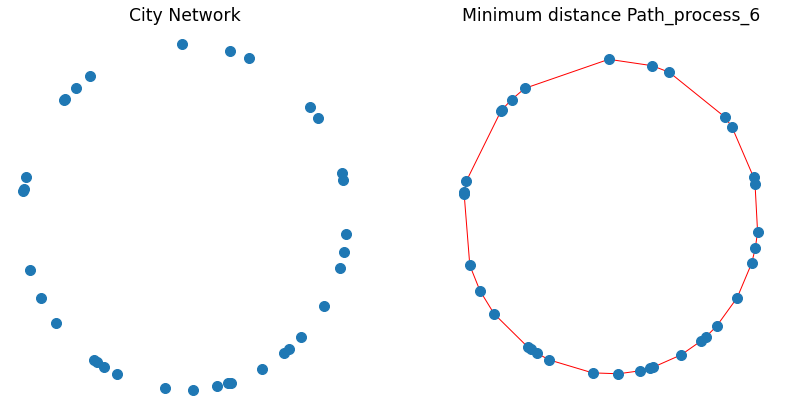

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

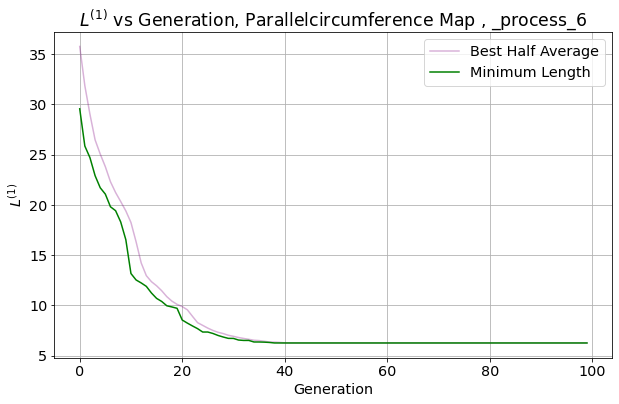

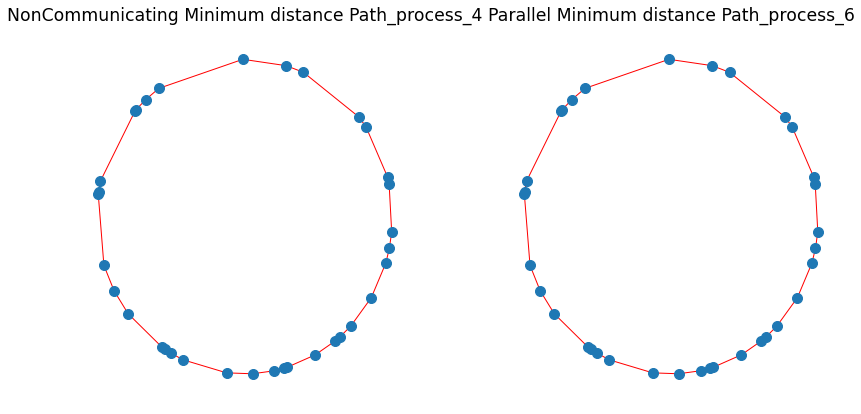

<Figure size 360x360 with 0 Axes>

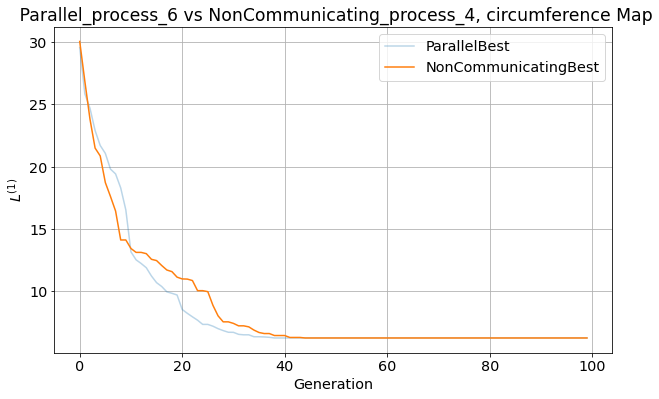

Minimum distance Noncommunicating =  6.25039
Minimum distance Parallel =  6.25039


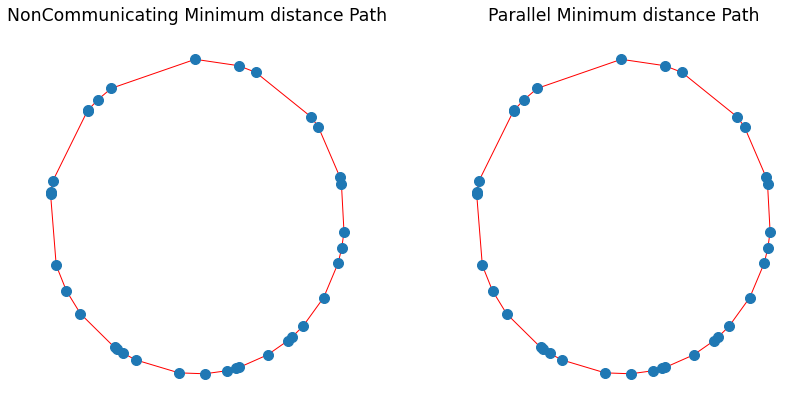

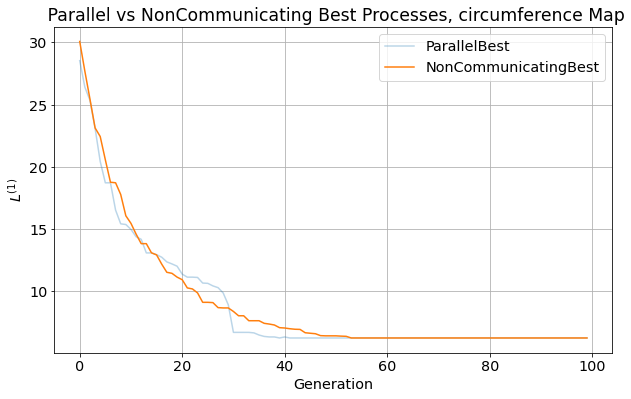

Best Parallel Process:  _process_5
Minimum distance Parallel =  6.25039
Best NonCommunicating Process:  _process_5
Minimum distance Noncommunicating =  6.25039


In [14]:
plot_all("Parallelcircumference", "_process_6")
confront("circumference", "_process_6", "_process_4")
confront_best("circumference")

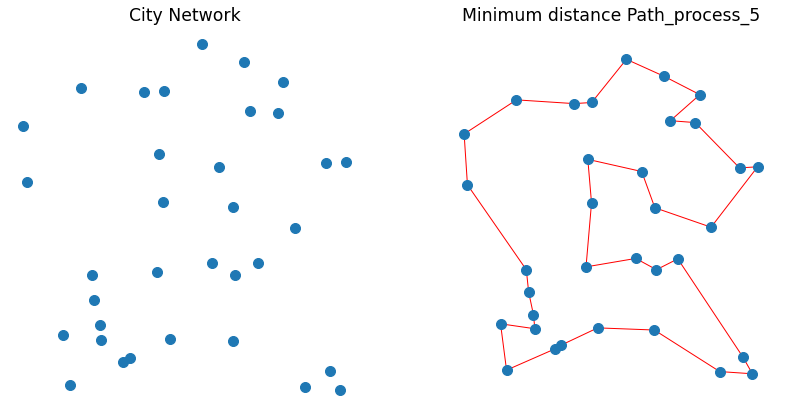

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

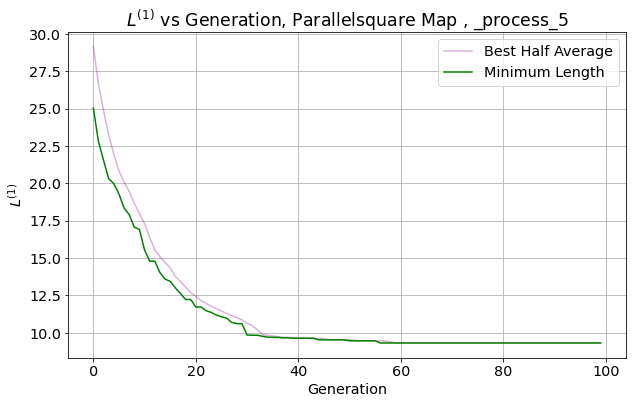

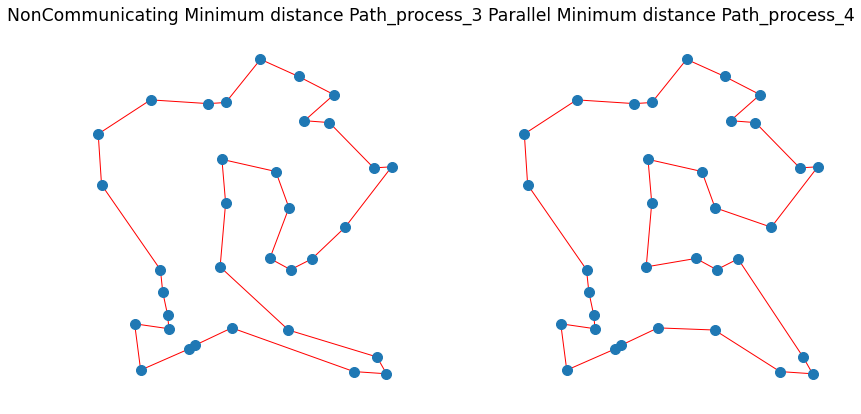

<Figure size 360x360 with 0 Axes>

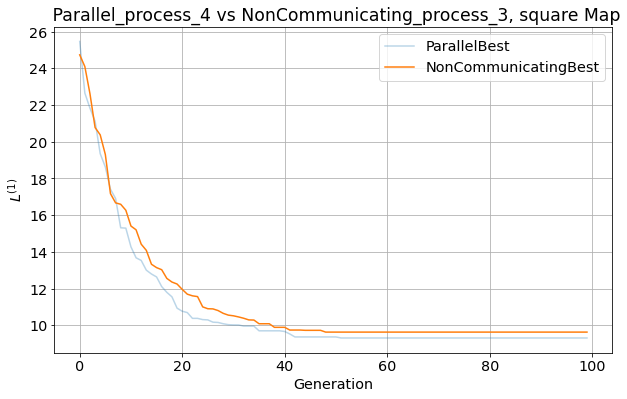

Minimum distance Noncommunicating =  9.63273
Minimum distance Parallel =  9.31297


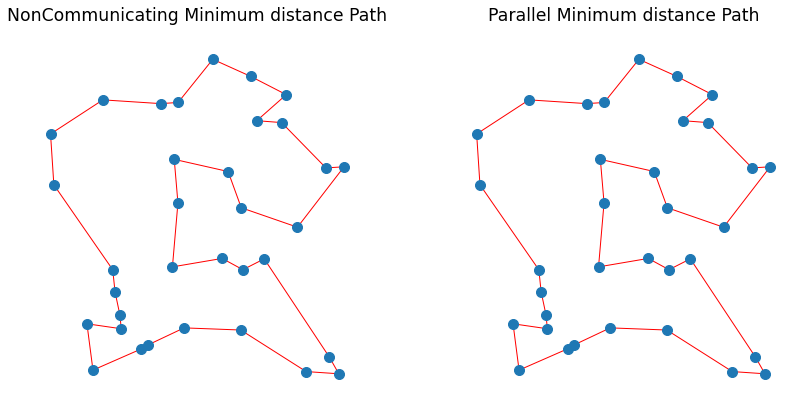

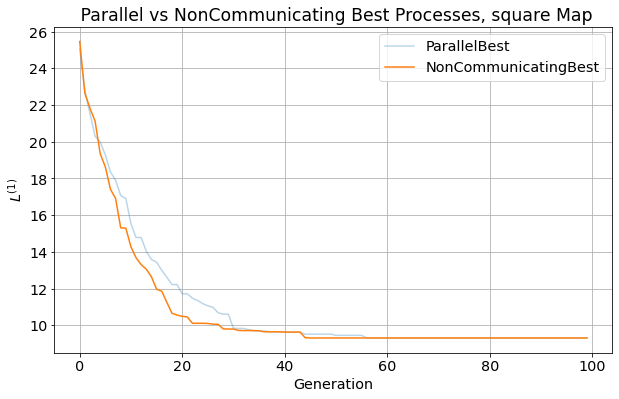

Best Parallel Process:  _process_5
Minimum distance Parallel =  9.31297
Best NonCommunicating Process:  _process_5
Minimum distance Noncommunicating =  9.31297


In [15]:
plot_all("Parallelsquare", "_process_5")
confront("square","_process_4", "_process_3")
confront_best("square")

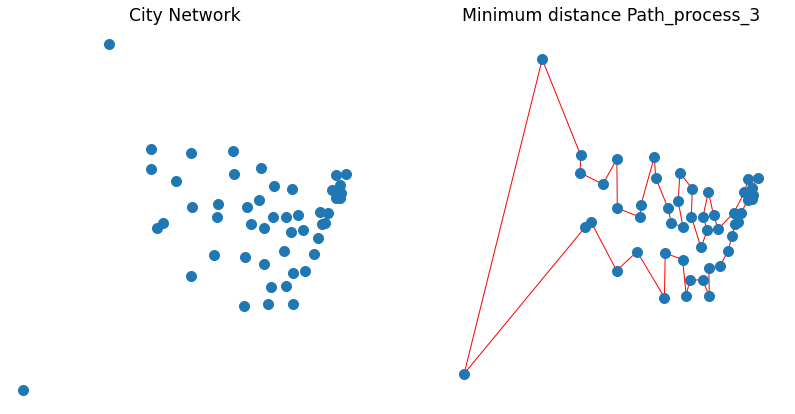

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

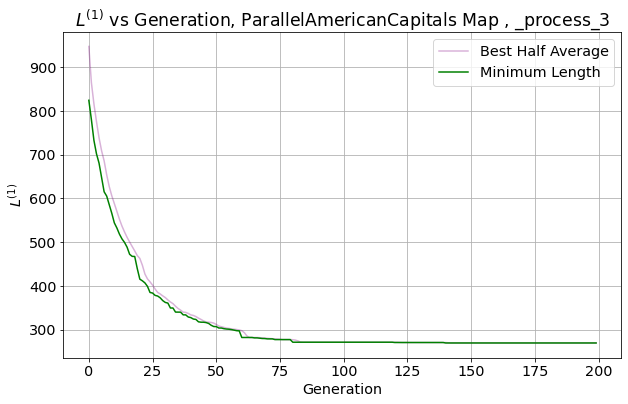

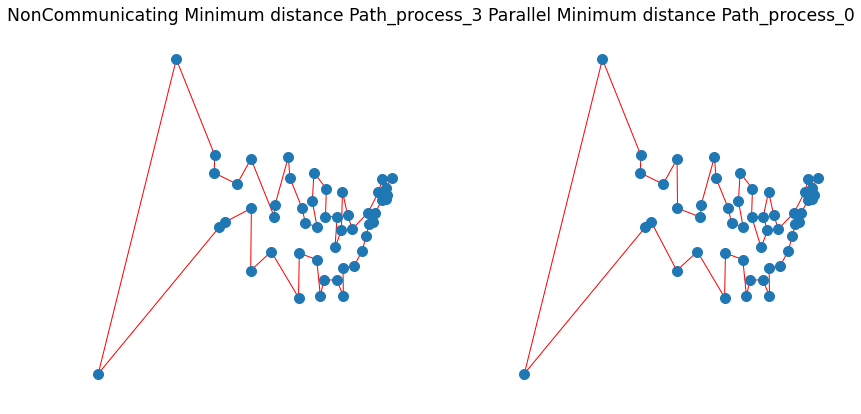

<Figure size 360x360 with 0 Axes>

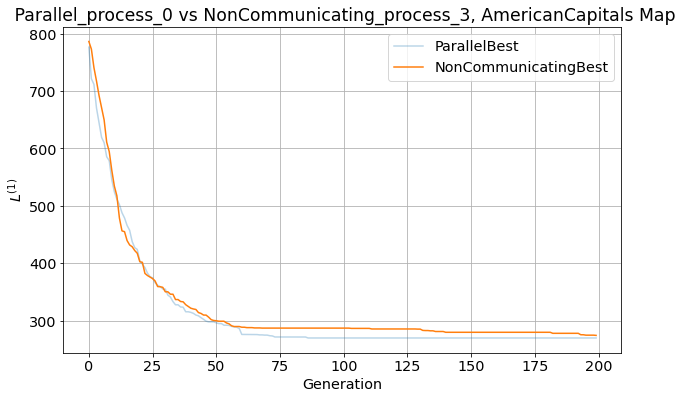

Minimum distance Noncommunicating =  274.145
Minimum distance Parallel =  269.646


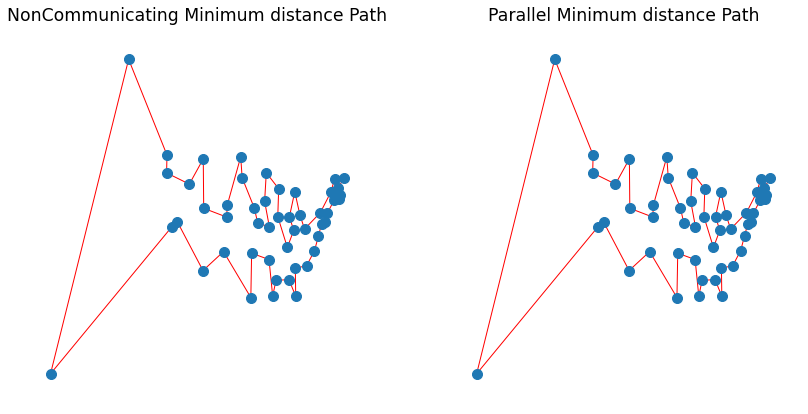

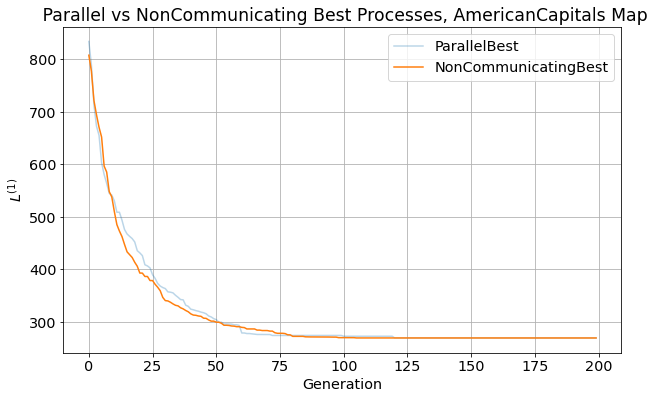

Best Parallel Process:  _process_5
Minimum distance Parallel =  269.646
Best NonCommunicating Process:  _process_2
Minimum distance Noncommunicating =  269.646


In [9]:
plot_all("ParallelAmericanCapitals","_process_3")
confront("AmericanCapitals", "_process_0", "_process_3")
confront_best("AmericanCapitals")

The parallel algorithm is not systematically better for all processes. However, it seems like it reaches a better minimum more often that the non parallelized algorithm. In the long run, both options reach the "supposed" minimum. In particular, the best of all the processes reaches the same final fitness for both options. It is easier for a non communicating process to miss out on the global minimum, by ending up in a local minimum.